In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [3]:
# Seed for reproducibility
np.random.seed(0)

# Generate synthetic time-series data
data_length = 300
data = np.sin(np.linspace(0, 20, data_length)) + np.random.normal(scale=0.5, size=data_length)
# Introduce anomalies
data[50] += 6  # Anomaly 1
data[150] += 7 # Anomaly 2
data[250] += 8 # Anomaly 3

In [4]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 10
sequences = create_sequences(data, window_size)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(window_size, 5),
            nn.ReLU(),
            nn.Linear(5, 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, window_size),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
sequences = torch.tensor(sequences, dtype=torch.float32)

In [7]:
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(sequences)
    loss = criterion(output, sequences)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 10, Loss: 1.2954978942871094
Epoch 20, Loss: 1.291107416152954
Epoch 30, Loss: 1.2869057655334473
Epoch 40, Loss: 1.2832341194152832
Epoch 50, Loss: 1.2798320055007935
Epoch 60, Loss: 1.276674747467041
Epoch 70, Loss: 1.2737226486206055
Epoch 80, Loss: 1.2705121040344238
Epoch 90, Loss: 1.266237497329712
Epoch 100, Loss: 1.2602030038833618


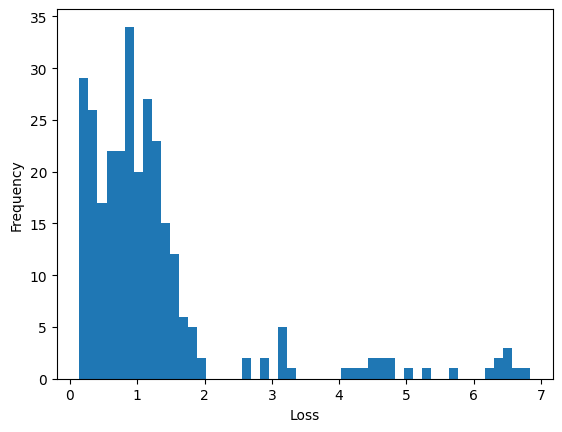

Anomaly threshold: 3.850060224533081
Anomalies found at positions: [141 142 143 144 145 146 147 148 149 150 241 242 243 244 245 246 247 248
 249 250]


In [8]:
with torch.no_grad():
    predictions = model(sequences)
    losses = torch.mean((predictions - sequences)**2, dim=1)
    plt.hist(losses.numpy(), bins=50)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.show()

# Threshold for defining an anomaly
threshold = losses.mean() + 2 * losses.std()
print(f"Anomaly threshold: {threshold.item()}")

# Detecting anomalies
anomalies = losses > threshold
anomaly_positions = np.where(anomalies.numpy())[0]
print(f"Anomalies found at positions: {np.where(anomalies.numpy())[0]}")

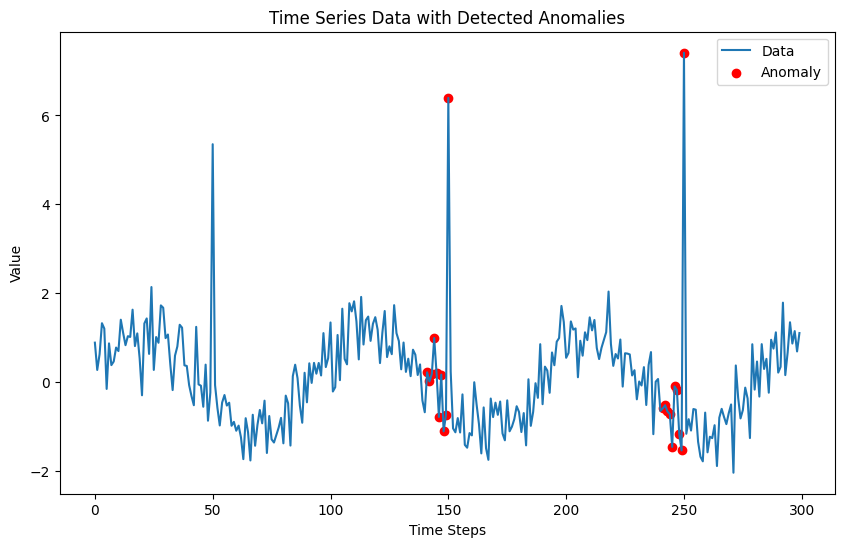

In [9]:
# Plotting anomalies on the time-series graph
plt.figure(figsize=(10, 6))
plt.plot(data, label='Data')
plt.scatter(anomaly_positions, data[anomaly_positions], color='r', label='Anomaly')
plt.title("Time Series Data with Detected Anomalies")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()